In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import numpy as np
import fiftyone as fo
from fiftyone import ViewField as F
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
from PIL import Image, ImageDraw

from horizon.dataloaders import HorizonDataset
from horizon.utils import draw_horizon

from utils.general import non_max_suppression
from utils.torch_utils import select_device
from models.common import DetectMultiBackend
from horizon.models import HorizonModel

In [3]:
dataset_name = "TRAIN_THERMAL_DATASET_2023_06_16bit"
train_tag, val_tag = "TRAIN_v0", "VAL_v0"
imgsz = 640
weights = '../yolos/yolov5n_T16-8_D2306-v0_9C.pt'

dataset_name = "RGB_train_2023-03-28_local"
train_tag, val_tag = "val", "train"
imgsz = 1280
weights = '../yolos/yolov5n6_RGB_D2304-v1_9C.pt'

horizon_augment = A.Compose([
    A.LongestMaxSize(max_size=imgsz),
    A.HorizontalFlip(p=0.5),
    A.PadIfNeeded(min_height=imgsz, min_width=imgsz, border_mode=cv2.BORDER_CONSTANT),  # letterbox
    A.ShiftScaleRotate(p=1, shift_limit=0.1, scale_limit=0.25, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT),
    # A.RandomCrop(height=imgsz, width=imgsz),
    A.Normalize(mean=0.0, std=1.0),  # img = (img - mean * max_pixel_value) / (std * max_pixel_value)
    ToTensorV2(p=1.0),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
if "RGB" in dataset_name:
    horizon_augment.transforms.insert(0, A.RandomBrightnessContrast(p=0.5))
    horizon_augment.transforms.insert(0, A.HueSaturationValue(p=0.5))
    horizon_augment.transforms.insert(0, A.CLAHE(p=0.05))
    horizon_augment.transforms.insert(0, A.Blur(p=0.2))

horizon_transform = A.Compose([
    A.LongestMaxSize(max_size=imgsz),
    A.HorizontalFlip(p=0.5),
    A.PadIfNeeded(min_height=imgsz, min_width=imgsz, border_mode=cv2.BORDER_CONSTANT),  # letterbox
    A.Normalize(mean=0.0, std=1.0),  # img = (img - mean * max_pixel_value) / (std * max_pixel_value)
    ToTensorV2(p=1.0),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

train_dataset = HorizonDataset(
    dataset=(fo.load_dataset(dataset_name)
             .match(F("ground_truth_pl.polylines.closed") == [False])
             .match_tags(train_tag)),
    transform=horizon_augment,
    target_format="pitch_theta",
    augment16bit=True
)

val_dataset = HorizonDataset(
    dataset=(fo.load_dataset(dataset_name)
             .match(F("ground_truth_pl.polylines.closed") == [False])
             .match_tags(val_tag)),
    transform=horizon_transform,
    target_format="pitch_theta"
)

print(f"{len(train_dataset)=}")
print(f"{len(val_dataset)=}")

len(train_dataset)=20629
len(val_dataset)=3137


tensor([[0.51275, 0.46575]], dtype=torch.float64)


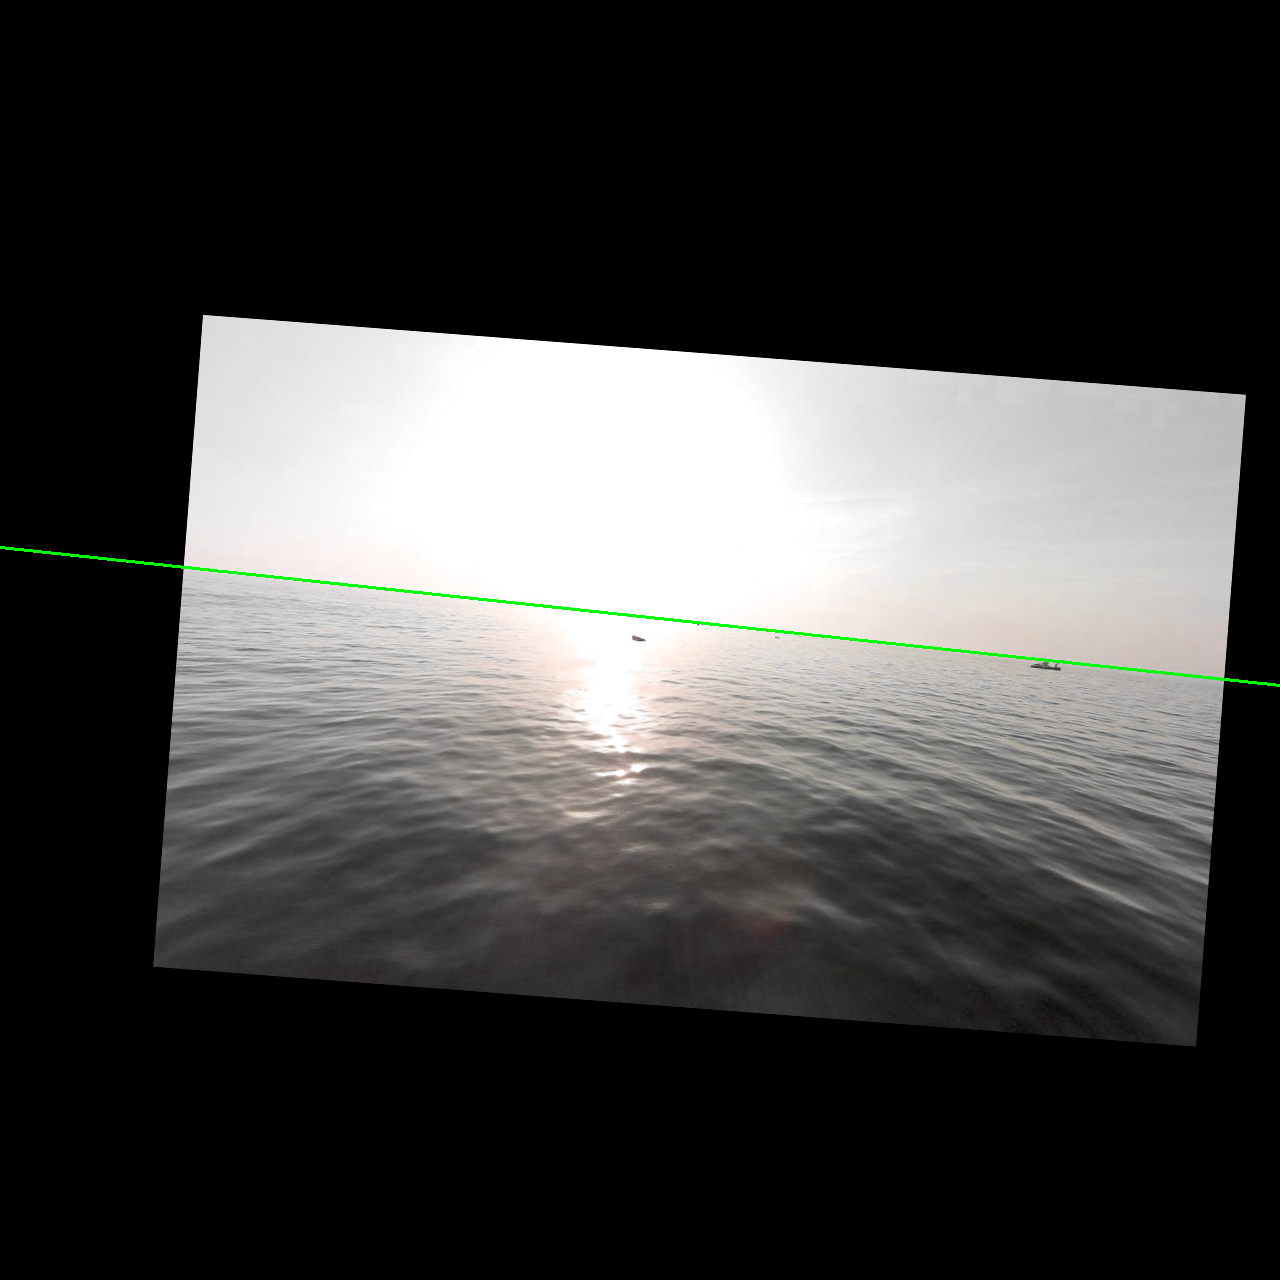

In [4]:
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=1)

for image, target in dataloader:
    break

print(target)
Image.fromarray(
    draw_horizon(
        np.array(image[0].permute(1, 2, 0) * 255).astype(np.uint8),
        keypoints=np.array(target[0]).reshape(-1, 2) if dataloader.dataset.target_format == "points" else None,
        pitch_theta=np.array(target[0]) if dataloader.dataset.target_format == "pitch_theta" else None,
        hough=np.array(target[0]) if dataloader.dataset.target_format == "hough" else None,
        diameter=2,
    )
)

In [5]:
device = select_device('') # smart selection
dnn = False
data = None
half = False
conf_thres = 0.25
iou_thres = 0.45
classes = None
agnostic_nms = True
max_det = 100
fuse = False

model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half, fuse=fuse)
model = HorizonModel(model)

def preprocess(im, model):
    im = im.clone()  # avoid inplace modifications
    im = im.to(model.device)
    im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
    if im.max() > 1:
        im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim
    return im

def inference(im, model):
    pred = model(im)
    return pred

def postprocess(pred):
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    return pred

def postprocess_x_pitch_theta(x_pitch, x_theta):
    # get maximum pitch and theta and normalise
    x_pitch, x_theta = x_pitch.softmax(1), x_theta.softmax(1)
    conf_pitch, pitch = x_pitch.max(1, keepdim=True)
    pitch = pitch / x_pitch.shape[-1]
    conf_theta, theta = x_theta.max(1, keepdim=True)
    theta = theta / x_theta.shape[-1]
    return torch.cat((pitch, conf_pitch), 1), torch.cat((theta, conf_theta), 1)

im = preprocess(image, model=model)
dets, x_pitch, x_theta = inference(im, model=model)
dets = postprocess(dets)
pitch, theta = postprocess_x_pitch_theta(x_pitch, x_theta)
pitch, theta = pitch.detach().cpu(), theta.detach().cpu()

YOLOv5 🚀 v7.0-13-g046025e Python-3.10.11 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)



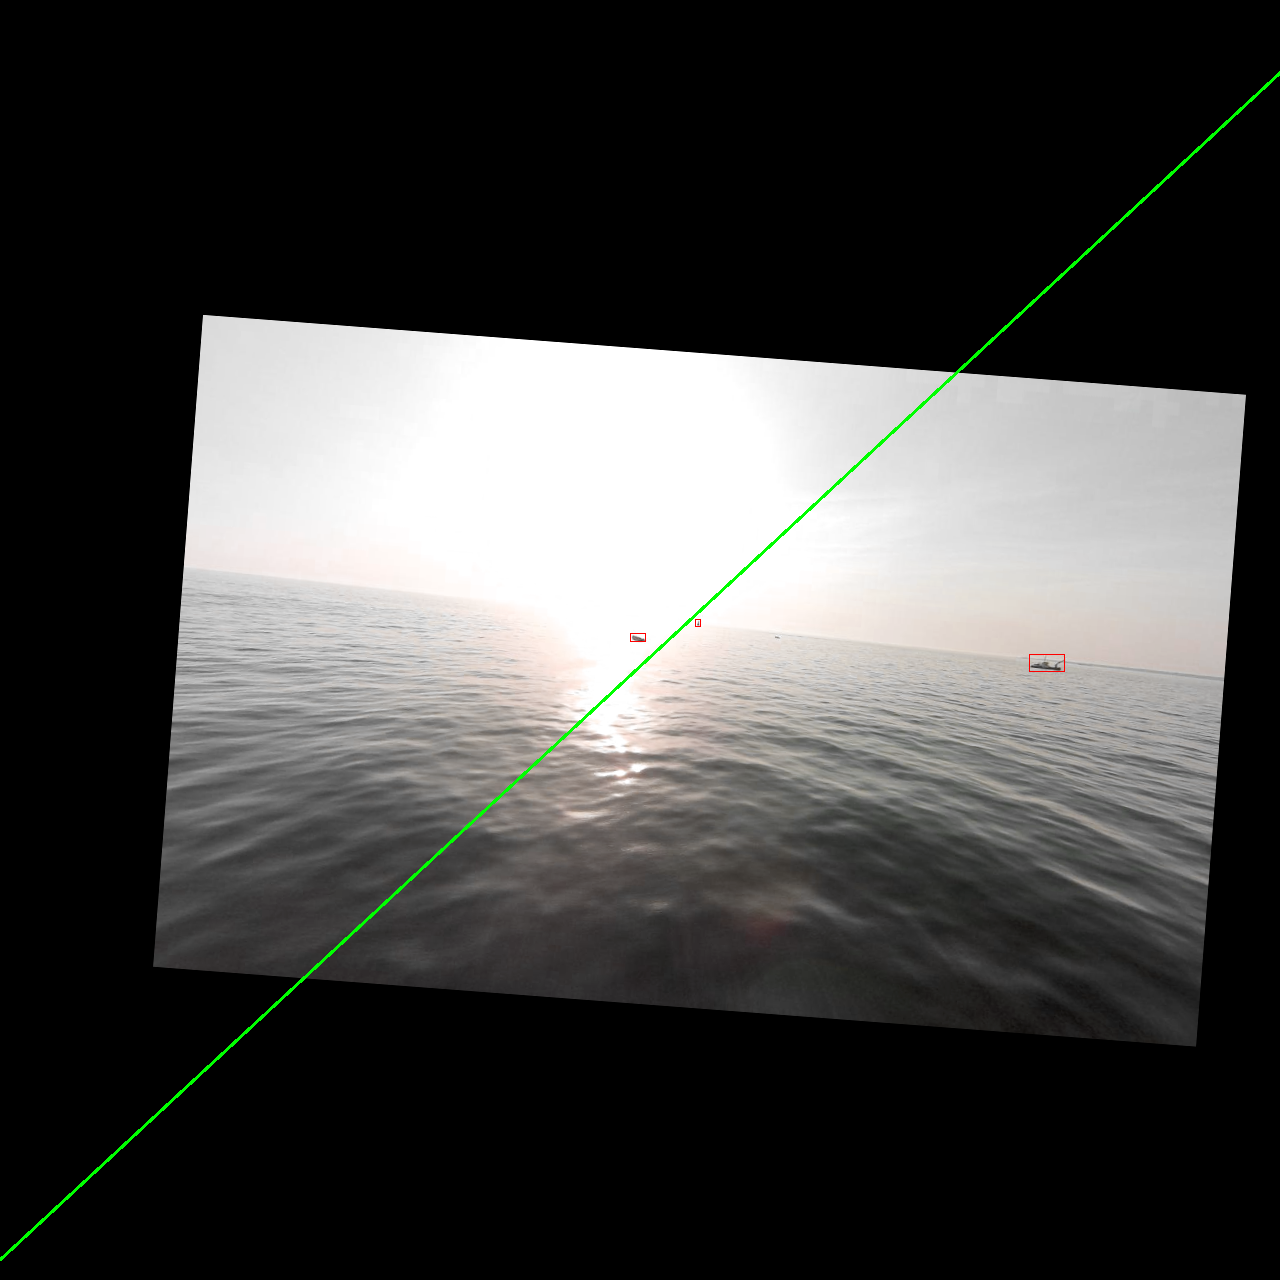

In [6]:
model.mode = None # "detection"
im = preprocess(image, model=model)
dets, x_pitch, x_theta = inference(im, model=model)
dets = postprocess(dets)
pitch, theta = postprocess_x_pitch_theta(x_pitch, x_theta)
pitch, theta = pitch.detach().cpu(), theta.detach().cpu()

I = (image[0].permute(1,2,0) * 255).numpy().astype(np.uint8)
I = draw_horizon(I, pitch_theta=(pitch[0][0], theta[0][0]), diameter=2)
I = Image.fromarray(I)
draw = ImageDraw.Draw(I)
for box in dets[0]:
    draw.rectangle(list(box[:4]), outline='red', width=1)
I

In [7]:
import torch.nn as nn
from torch.cuda import amp
from torch.optim.lr_scheduler import LambdaLR
import models.common
from utils.torch_utils import smart_optimizer, ModelEMA

dropout = 0.25
model = DetectMultiBackend(weights, device=torch.device('cuda'), dnn=dnn, data=data, fp16=half, fuse=fuse)
model = HorizonModel(model, cutoff=8 if imgsz==640 else 10, nc_pitch=500, nc_theta=500)

for m in model.modules():
    if isinstance(m, torch.nn.Dropout) and dropout is not None:
        m.p = dropout  # set dropout

for p in model.parameters():
        p.requires_grad = False  # freeze all layers

for m in model.model:
    if isinstance(m.i, int) and m.i <= model.cutoff:
        for p in m.parameters():
            p.requires_grad = True  # unfreeze backbone
    if isinstance(m, models.common.Classify):
        for p in m.parameters():
            p.requires_grad = True  # unfreeze classifier

for m in model.model:
    print(m.i, m.f, m.type)
model.info()

Model summary: 296 layers, 5051248 parameters, 3359304 gradients, 4.7 GFLOPs


0 -1 models.common.Conv
1 -1 models.common.Conv
2 -1 models.common.C3
3 -1 models.common.Conv
4 -1 models.common.C3
5 -1 models.common.Conv
6 -1 models.common.C3
7 -1 models.common.Conv
8 -1 models.common.C3
9 -1 models.common.Conv
10 -1 models.common.C3
11 -1 models.common.SPPF
12 -1 models.common.Conv
13 -1 torch.nn.modules.upsampling.Upsample
14 [-1, 8] models.common.Concat
15 -1 models.common.C3
16 -1 models.common.Conv
17 -1 torch.nn.modules.upsampling.Upsample
18 [-1, 6] models.common.Concat
19 -1 models.common.C3
20 -1 models.common.Conv
21 -1 torch.nn.modules.upsampling.Upsample
22 [-1, 4] models.common.Concat
23 -1 models.common.C3
24 -1 models.common.Conv
25 [-1, 20] models.common.Concat
26 -1 models.common.C3
27 -1 models.common.Conv
28 [-1, 16] models.common.Concat
29 -1 models.common.C3
30 -1 models.common.Conv
31 [-1, 12] models.common.Concat
32 -1 models.common.C3
33 [23, 26, 29, 32] models.yolo.Detect
c_pitch 10 models.common.Classify
c_theta 10 models.common.Classify


In [ ]:
from copy import deepcopy
from datetime import datetime
from tqdm import tqdm
from utils.general import TQDM_BAR_FORMAT
from torch.nn.utils import clip_grad_norm_

model.mode = "horizon"
device = model.device
epochs = 300
bs = 64 if imgsz == 640 else 16

trainloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)#, pin_memory=True)
testloader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)#, pin_memory=True)

optimizer = smart_optimizer(model, name="Adam", lr=0.001, momentum=0.9, decay=0.0001)

lrf = 0.001  # final lr (fraction of lr0)
# lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - lrf) + lrf  # cosine
lf = lambda x: (1 - x / epochs) * (1 - lrf) + lrf  # linear
scheduler = LambdaLR(optimizer, lr_lambda=lf)

loss_pitch = nn.CrossEntropyLoss(label_smoothing=0.0)
loss_theta = nn.CrossEntropyLoss(label_smoothing=0.0)

cuda = device != 'cpu'
scaler = amp.GradScaler(enabled=cuda)

ema = ModelEMA(model)
best_loss = 1e10

for epoch in range(epochs):
    tloss, vloss = 0.0, 0.0
    
    model.train()
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), bar_format=TQDM_BAR_FORMAT)
    for i, data in pbar:
        images, targets = data
        images, targets = images.to(device), targets.to(device)

        # forward
        x_pitch, x_theta = model(images)

        # process targets
        pitch, theta = targets[...,0], targets[...,1]
        pitch = (pitch * model.nc_pitch).long().clamp(0, model.nc_pitch - 1)
        theta = (theta * model.nc_theta).long().clamp(0, model.nc_theta - 1)

        # backward
        loss = loss_pitch(x_pitch, pitch) + loss_theta(x_theta, theta)
        scaler.scale(loss).backward()

        # Optimize
        scaler.unscale_(optimizer)  # unscale gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # clip gradients
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        if ema:
            ema.update(model)

        tloss = (tloss * i + loss.item()) / (i + 1)  # update mean losses
        mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
        pbar.desc = f"{'train':>6}{f'{epoch + 1}/{epochs}':>10}{mem:>10}{tloss:>12.3g}" + ' ' * 10

    scheduler.step()

    model.eval()
    pbar = tqdm(enumerate(testloader), total=len(testloader), bar_format=TQDM_BAR_FORMAT)
    for i, data in pbar:
        images, targets = data
        images, targets = images.to(device), targets.to(device)

        with torch.no_grad():
            # forward
            x_pitch, x_theta = ema.ema(images)

            # process targets
            pitch, theta = targets[...,0], targets[...,1]
            pitch = (pitch * model.nc_pitch).long().clamp(0, ema.ema.nc_pitch - 1)
            theta = (theta * model.nc_theta).long().clamp(0, ema.ema.nc_theta - 1)

            # backward
            loss = loss_pitch(x_pitch, pitch) + loss_theta(x_theta, theta)

            vloss = (vloss * i + loss.item()) / (i + 1)  # update mean losses
        mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
        pbar.desc = f"{'val':>6}{f'{epoch + 1}/{epochs}':>10}{mem:>10}{vloss:>12.3g}" + ' ' * 10

    if vloss < best_loss:
        best_loss = vloss
        ckpt = {
            'epoch': epoch,
            'model': deepcopy(ema.ema),  # deepcopy(de_parallel(model)).half(),
            'ema': None,  # deepcopy(ema.ema).half(),
            'updates': ema.updates,
            'optimizer': None,  # optimizer.state_dict(),
            'date': datetime.now().isoformat()}
        torch.save(ckpt, f'./hmodel_{epoch + 1}_{vloss:.2g}.pt')
        del ckpt

optimizer: Adam(lr=0.001) with parameter groups 77 weight(decay=0.0), 83 weight(decay=0.0001), 83 bias
 train     1/300     8.14G        6.91          : 100%|██████████| 1290/1290 10:22
   val     1/300     8.14G        9.57          : 100%|██████████| 197/197 01:17
 train     2/300     8.14G        5.23          : 100%|██████████| 1290/1290 10:25
   val     2/300     8.14G        14.4          : 100%|██████████| 197/197 01:17
 train     3/300     8.14G        4.71          :  56%|█████▌    | 716/1290 05:47IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 train     9/300     8.14G        3.88          : 100%|██████████| 1290/1290 10:22
   val     9/300     8.14G        46.8          : 100%|██████████| 197/197 01:18
 train

In [ ]:
ema.ema.mode = None # "detection"
ema.ema.eval()

dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1)

for image, target in dataloader:
    break

def postprocess_x_pitch_theta(x_pitch, x_theta):
    # get maximum pitch and theta and normalise
    x_pitch, x_theta = x_pitch.softmax(1), x_theta.softmax(1)
    _, pitch = x_pitch.max(1, keepdim=True)
    pitch = pitch / x_pitch.shape[-1]
    _, theta = x_theta.max(1, keepdim=True)
    theta = theta / x_theta.shape[-1]
    print(f"{pitch=}, {theta=}")
    pitch = torch.linspace(0, 1, x_pitch.shape[-1], device=x_pitch.device).unsqueeze(0) * x_pitch
    theta = torch.linspace(0, 1, x_theta.shape[-1], device=x_theta.device).unsqueeze(0) * x_theta
    pitch = pitch.sum(1, keepdim=True)
    theta = theta.sum(1, keepdim=True)
    print(f"{pitch=}, {theta=}")
    return pitch, theta

with torch.no_grad():
    im = preprocess(image, model=ema.ema)
    dets, x_pitch, x_theta = inference(im, model=ema.ema)
    dets = postprocess(dets)
    pitch, theta = postprocess_x_pitch_theta(x_pitch, x_theta)
    pitch, theta = pitch.detach().cpu(), theta.detach().cpu()
print(f"{target=}")

I = (image[0].permute(1,2,0) * 255).numpy().astype(np.uint8)
I = draw_horizon(I, pitch_theta=(pitch[0][0], theta[0][0]), color=(0,0,255))
I = draw_horizon(I, pitch_theta=(target[0][0], target[0][1]), color=(0,255,0))
I = Image.fromarray(I)
draw = ImageDraw.Draw(I)
for box in dets[0]:
    draw.rectangle(list(box[:4]), outline='red', width=1)
I